# Part 5. Digital Modulation

**Objectives:** 
* Understand some simple ways to send digital information
* Use Morse code to encode a message 
* Transmit and receive a digtal message over an audio channel

**Required Materials**
* Computer speakers
* Python audio libraries noted below
* Printouts of the Morse Code chart (file: morse.pdf) for each lab participant. 

## Loading the Necessary Libraries


In [1]:
# These are the minimum sound libraries required. 

import scipy.io.wavfile as wavfile
import sounddevice as sd
import pyaudio

In [2]:
# Library for visualizing the sound recordings

import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# Helper libraries

import numpy as np
import time


In [4]:
# The code in this block loads some elements for adding interactive 
# widgets to the code

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import IPython.display as display



In [5]:
# This notebook uses a couple of new functions from NumPy to transform a signal into a frequency
# representation

import numpy.fft

## Digital Signaling

Until now, we have considered audio signals, and we showed how to multiplex audio signals together to transmit them at different frequencies. We showed that radio stations and cellular telephony also divide up their frequency bands into sub-bands that are used by different stations or service providers.

Modern mobile telephony systems do not send analog signals, though. Much of the data is internet traffic, including web pages and video. However, even voice calls are converted into a digital stream of bits that is compressed (to reduce the amount of data required) and then sent as a bit stream.

In this section, we will learn about two basic ways to send digital data. The two ways we consider are not those used in mobile telephony but are techniques that are easy to understand when the communications medium is audio instead of radio frequencies.  The techniques used for mobile telephony and WiFi build on the techniques discussed here by adding more levels and additional sinusoids to carry information.


### On-Off Keying

One of the simplest digital signaling techniques traces its roots back to the original application of radio, which was wireless transmission of telegraph signals. In telegraph, the operator uses a "key" (a button) to either send a tone or not send a tone. Thus the tone is either "on" or "off", resulting in On-Off Keying.

*Modulation* is the process by information is encoded for transmission on a channel. One of the simplest ways is to modulate information for radio transmission is to change some property of a sinusoid at the desired frequency. In the case of on-off keying, the sinusoid can be multiplied by an information sequence that consists of 0s and 1s to turn the sinusoid on and off. For instance, the sequence "101101" can be sent as shown below:

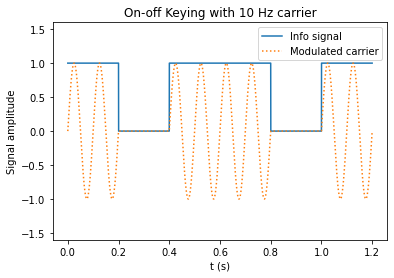

In [6]:

f_c = 10 # 10 Hz sinusoid for plotting purposes
info = np.array([
    [1,0,1,1,0,1]
])
bit_duration=0.2
rate=44100

# Create the sinusoid:
total_duration=np.shape(info)[1]*bit_duration
t=np.linspace(0, total_duration, int(total_duration*rate) )
carrier = np.sin(2 * np.pi * f_c * t)

# Each bit needs to last bit_duration*rate samples:
repeated_bits = np.repeat(info.T, bit_duration * rate, axis=1)

# Make the repeated bits into one long signal vector
info_signal = np.reshape(repeated_bits, -1)

output_signal= info_signal*carrier

plt.plot(t, info_signal, label='Info signal')
plt.plot(t, output_signal, ':', label='Modulated carrier')
plt.ylim(-1.6,1.6)
plt.legend(loc=1)
plt.xlabel('t (s)')
plt.ylabel('Signal amplitude')
plt.title('On-off Keying with 10 Hz carrier');


**Question 5.1 What problems might there be with this scheme? How might you avoid those problems?**

*Demodulation* is the process of taking a modulated signal and recovering the information. Demodulation for this type of signal can be achieved in different ways. We will use a really simple one: square the signal and then average it over each symbol interval. Then we can compare the average to a threshold to make decisions.

Let's run the same code as above but add in some noise and our new demodulation process. 

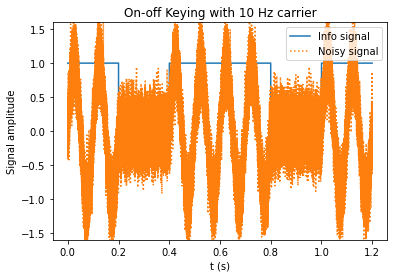

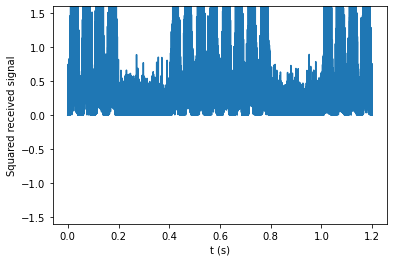

Average value over each symbol is
[0.57313194 0.06220988 0.56495164 0.56010368 0.06358311 0.56018468]

We can turn these into 0s and 1s by comparing to a threshold midway between 0 and 0.5
(in case there is noise):

Average value over each symbol is [1 0 1 1 0 1]



In [7]:
noise_deviation = 0.25

f_c = 10 # 10 Hz sinusoid for plotting purposes
info = np.array([
    [1,0,1,1,0,1]
])
bit_duration=0.2
rate=44100

# Create the sinusoid:
total_duration=np.shape(info)[1]*bit_duration
t=np.linspace(0, total_duration, int(total_duration*rate) )
carrier = np.sin(2 * np.pi * f_c * t)

# Each bit needs to last bit_duration*rate samples:
repeated_bits = np.repeat(info.T, bit_duration * rate, axis=1)

# Make the repeated bits into one long signal vector
info_signal = np.reshape(repeated_bits, -1)

output_signal= info_signal*carrier

# Now add noise
noisy_signal = output_signal + noise_deviation*np.random.randn(int(total_duration*rate))

                                                               
# Plot the noisy signal    
plt.plot(t, info_signal, label='Info signal')
plt.plot(t, noisy_signal, ':', label='Noisy signal')
plt.ylim(-1.6,1.6)
plt.legend(loc=1)
plt.xlabel('t (s)')
plt.ylabel('Signal amplitude')
plt.title('On-off Keying with 10 Hz carrier');






squared_signal=noisy_signal**2
plt.figure()
plt.plot(t, squared_signal, label='Squared Modulated Signal')
plt.ylim(-1.6,1.6)
plt.xlabel('t (s)')
plt.ylabel('Squared received signal')
plt.show()
# Split the squared signal into symbols
symbols = squared_signal.reshape( -1, int(bit_duration*rate))

# Average the values for each symbol
print(f'Average value over each symbol is')
print(f'{symbols.mean(axis=1)}')
print()

print('We can turn these into 0s and 1s by comparing to a threshold midway between 0 and 0.5')
print ('(in case there is noise):')

print()
print(f'Average value over each symbol is {1*(symbols.mean(axis=1)>0.25)}')
print()


**Activity 5.2: Adjust the `noise_variance` parameter above to see how it affects the performance of this system.** 

* How high can `noise_variance` be before you start to see a large number of errors. 
* Is one type of error more prevalent than another? Why do you think that is the case? 
* Can you think of any way to improve the performance of this detector when the noise is large? 
* Try to modify the code to improve the performance when the noise is large. Were you successful? If so, what did you do and why?

### Audio Version

In our first example of On-Off Keying, we used a 10 Hz carrier, so that the carrier could be  clearly seen when we plotted the signal. However, during our first lab on audio frequencies, you probably found that such low frequencies are hard for most people to hear.

Lets' modify the code above to use a 440 Hz carrier and play the digital signal as audio:

In [8]:

f_c = 440 # 440 Hz sinusoid for audio signal
info = np.array([
    [1,0,1,1,0,1]
])
bit_duration=0.2
rate=44100

# Create the sinusoid:
total_duration=np.shape(info)[1]*bit_duration
t=np.linspace(0, total_duration, int(total_duration*rate) )
carrier = np.sin(2 * np.pi * f_c * t)


# Each bit needs to last bit_duration*rate samples:
repeated_bits = np.repeat(info.T, bit_duration * rate, axis=1)

# Make the repeated bits into one long signal vector
info_signal = np.reshape(repeated_bits, -1)

output_signal= info_signal*carrier

sd.play(output_signal)



**Activity 5.3:** The following code will generate a message that consists of a 1 followed by 5 random bits. Listen to the message and then enter what you think the message was as a string of five 0s and 1s, like: 01101. **Only enter the 5 bits after the initial 1.** Try this several times and see how well you can do. Write down your record as:

\# correct / # tries

(like 3/5)

In [ ]:
info=np.hstack((np.array([1]), np.random.randint(2, size=5)))
info=info[np.newaxis, :]
bit_duration=0.2
rate=44100

# Create the sinusoid:
total_duration=np.shape(info)[1]*bit_duration
t=np.linspace(0, total_duration, int(total_duration*rate) )
carrier = np.sin(2 * np.pi * f_c * t)

# Each bit needs to last bit_duration*rate samples:
repeated_bits = np.repeat(info.T, bit_duration * rate, axis=1)

# Make the repeated bits into one long signal vector
info_signal = np.reshape(repeated_bits, -1)

output_signal= info_signal*carrier

sd.play(output_signal)

print("Enter what you believe the 5-bit information to be: ", end='')
guess=input()
print(())

# Analyze the input
print("Bit #   |   True bit   |  Your Guess")
print("------------------------------------")
num_errors=0
for i in range(5):
    bit=int(guess[i])
    if bit != info[0,i+1]:
        check='X'
        num_errors+=1
    else:
        check=''
    print(f'   {i+1}    |       {info[0,i+1]}      |     {bit} {check}')
    
print()
if num_errors==1:
    print(f'You made 1 error')
else:
    print(f'You made {num_errors} errors')

## On-Off Keying: Morse Code

One of the problems with this signaling scheme is that timing information can be hard to detect when there is a long string of 0s or 1s. This is especially true if a human is being the demodulator!  Remember that On-Off Keying originated with the telegraph. In telegraphs signaling, the two symbols are instead a short tone (called **dit**) and a long tone (called **dah**).  When writing out these symbols, we use a period . to represent dit and a dash - to represent dah.

For English language transmission, telegraph commonly used Morse Code  to make transmission more efficient. Morse code works by sending shorter combinations of dit and dah to represent common letters (like *e* and *t*) and longer combinations to represent uncommon letters (like *v* and *z*).  Below is a Morse Code table  that maps letters to the serious of dits and dahs:

![From Rhey T. Snodgrass & Victor F. Camp, 1922](../plots/morse.svg)

**Lab Organizer:** Give each team a copy of this Morse Code chart.

In [ ]:
dit_duration=0.20


codex = {
    'cat' : np.array([[1,1,1,0,1,0,1,1,1,0,1,0,0,0,1,0,1,1,1,0,0,0,1,1,1]]),
    'dog' : np.array([[1,1,1,0,1,0,1,0,0,0,1,1,1,0,1,1,1,0,1,1,1,0,0,0,1,1,1,0,1,1,1,0,1]]),
    'fox' : np.array([[1,0,1,0,1,1,1,0,1,0,0,0,1,1,1,0,1,1,1,0,1,1,1,0,0,0,1,1,1,0,1,0,1,0,1,1,1]]),
    'bear': np.array([[1,1,1,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,1,1,1,0,0,0,1,0,1,1,1,0,1]])
}
animals=list(codex.keys())
animal=animals[ np.random.randint(len(animals))]

info=codex[animal]
rate=44100

# Create the sinusoid:
total_duration=np.shape(info)[1]*dit_duration
t=np.linspace(0, total_duration, int(total_duration*rate) )
carrier = np.sin(2 * np.pi * f_c * t)

# Each bit needs to last bit_duration*rate samples:
repeated_bits = np.repeat(info.T, dit_duration * rate, axis=1)

# Make the repeated bits into one long signal vector
info_signal = np.reshape(repeated_bits, -1)

output_signal= info_signal*carrier


time.sleep(1)
sd.play(output_signal)
print('Which of these animals was transmitted?')
print('1 - cat')
print('2 - dog')
print('3 - fox')
print('4 - bear')
print()
print('Type the number and press Enter', end='')

guess=input()

if animals[int(guess)-1] == animal:
    print(f'Correct! The animal was {animal}')
else:
    print(f'Incorrect. The animal was {animal}')



**Activity 5.4:** Note that this code uses a parameter called `dit_duration`. Try setting `dit_duration` to a smaller value, such as 0.05. Write down the smallest value of `dit_durration` at which you can still reliably decode the message.

## Review

* *Modulation* is the process by information is encoded for transmission on a channel.
* In *on-off keying*, an information stream is conveyed by turning a carrier on and off.
* *Demodulation* is the process of taking a modulated signal and recovering the information.
* *Morse Code* is a way to efficiently modulate English letters and numbers as a sequence of tones of varying lengths.


